In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Basic imports
import tensorflow as tf
import numpy as np
import random
import time
from numpy import array
import keras
import sys
from matplotlib import pyplot
from pylab import *

In [15]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, Activation, AveragePooling2D
from keras.layers import MaxPooling2D, Conv3D, MaxPooling3D, Dropout, Lambda
import numpy as np
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras.layers.merge import Concatenate
from keras.engine.input_layer import Input
from keras.backend import flatten
from keras.utils import plot_model

# The function to define the CNN network
def network(x1,x2,cube):
  # originally we have one 29*29 2D patch, one 87*87 2D patch and one 13*13*13 3D patch
  # in the assignment, we will vary the number of patches and the data they include to see what kind of influences these modifications would have
  x1_1 = Conv2D(32, (5, 5), padding='same',use_bias=False)(x1) 
  x1_1 = MaxPooling2D()(x1_1)
  x1_1 = BatchNormalization()(x1_1)
  x1_1 = Activation("relu")(x1_1)

  x2_1 = AveragePooling2D((5,5),strides=3)(x2)
  x2_1 = Conv2D(32, (5, 5), padding='same',use_bias=False)(x2_1) 
  x2_1 = MaxPooling2D()(x2_1)
  x2_1 = BatchNormalization()(x2_1)
  x2_1 = Activation("relu")(x2_1)
  
  cube_1 = Conv3D(32, (5, 5, 5), padding='same',use_bias=False)(cube) 
  cube_1 = MaxPooling3D()(cube_1)
  cube_1 = BatchNormalization()(cube_1)
  cube_1 = Activation("relu")(cube_1) 
  
  #Layer 2
  x1_2 = Conv2D(50, (3, 3), padding='same',use_bias=False)(x1_1) 
  x1_2 = MaxPooling2D()(x1_2)
  x1_2 = BatchNormalization()(x1_2)
  x1_2 = Activation("relu")(x1_2)

  x2_2 = AveragePooling2D((3,3),strides=3)(x2_1)
  x2_2 = Conv2D(50, (3, 3), padding='same',use_bias=False)(x2_2) 
  x2_2 = MaxPooling2D()(x2_2)
  x2_2 = BatchNormalization()(x2_2)
  x2_2 = Activation("relu")(x2_2)
  
  cube_2 = Conv3D(50, (3, 3, 3), padding='same',use_bias=False)(cube_1) 
  cube_2 = MaxPooling3D()(cube_2)
  cube_2 = BatchNormalization()(cube_2)
  cube_2 = Activation("relu")(cube_2) 
  
  x1_2 = Flatten()(x1_2)
  x2_2 = Flatten()(x2_2)
  cube_2 = Flatten()(cube_2)
  
  fc = Concatenate()([x1_2,x2_2,cube_2])
  
  # Dropout is defined here
  fc = Dropout(0.5)(fc)
  #Dense Layer
  dense_1 = Dense(1500,use_bias=False, activation="relu")(fc)
  #dense_1 = Dropout(0.5)(dense_1)
  dense_1 = BatchNormalization()(dense_1)
  
  dense_2 = Dense(1500,use_bias=False, activation="relu")(dense_1)
  #dense_2 = Dropout(0.5)(dense_2)
  dense_2 = BatchNormalization()(dense_2)
  
  output = Dense(135,activation="softmax")(dense_2)
  
  return output

# END of defining the CNN network

# Next, the CNN model is defined. 
# test.summary() will show the defined model in details.
x1 = Input(shape=(29,29,1))
x2 = Input(shape=(87,87,1))
cube = Input(shape=(13,13,13,1))
test = Model(inputs=[x1,x2,cube], outputs=network(x1,x2,cube))
test.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

# The structure of the CNN network is displayed
test.summary()

# The diagram of the structure is saved to a file
plot_model(test,to_file='drive/My Drive/Colab Notebooks/model_diagram.png',show_shapes=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 87, 87, 1)    0                                            
__________________________________________________________________________________________________
average_pooling2d_5 (AveragePoo (None, 28, 28, 1)    0           input_8[0][0]                    
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 29, 29, 1)    0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 28, 28, 32)   800         average_pooling2d_5[0][0]        
__________________________________________________________________________________________________
input_9 (I

TRAINING DATA GENERATION

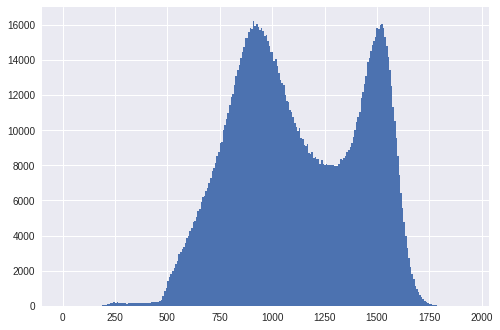

**** Display some sample values for reference: z=125; x=125; y=[125:140] 
raw:  [   0.       702.4829   827.6591   961.05835 1154.9955  1359.2179
 1464.9822  1397.3713  1203.547    966.5984   772.7163   686.564
  597.32086  538.85724  510.1532 ]
label:  [  0. 125. 125. 125. 125.  14.  14.  14.  14.  97.  97.  97.  97.  97.
  97.]
(373, 342, 342)
Total number of voxels in the Patient =  43627572
Total number of non-zero voxels =  1543898
Next is Image Equalization


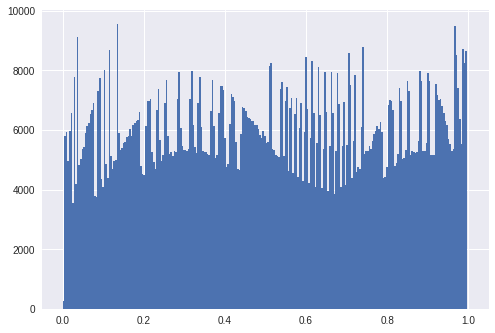

equalize:  [0.         0.07793374 0.1876256  0.36516523 0.5635231  0.70861965
 0.81318265 0.74016535 0.60045975 0.37090978 0.13395469 0.06968046
 0.02745098 0.01176471 0.00566974]
Number of patient (Length of dataset) =  5


In [16]:
import tensorflow as tf
import numpy as np
import random
import time
from numpy import array
import keras
import sys
import copy
import matplotlib.pyplot as plt

# The two functions for normalization are defined.
def whitening(image):
    """Whitening. Normalises image to zero mean and unit variance."""

    image = image.astype(np.float32)

    mean = np.mean(image)
    std = np.std(image)

    if std > 0:
        ret = (image - mean) / std
    else:
        ret = image * 0.
    return ret

def normalize(image):
    #Normalize the image 
    
    image = image.astype(np.float32)
    tmp = np.shape(image)
    print(tmp[0],tmp[1],tmp[2])
    #if image > 0:
    #  i_min = image.min()
    #  i_max = image.max()
    #  ret = (image - i_min) * 255/ (i_max - i_min)
    #else:
    #  ret = 0.     
      
  
    print("min ", np.min(image))
    print("max ", np.max(image))
    return image
  
  
def histeq(im,nbr_bins=256):
  """This is for image equalization"""
  #get image histogram
  imhist,bins = np.histogram(im.flatten(),nbr_bins,normed=True)
   
  cdf = imhist.cumsum() #cumulative distribution function
  
  cdf_m = np.ma.masked_equal(cdf,0)#mask the background voxels 
    
  # the main step of histogram equalization
  cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min()) 
   
  cdf = np.ma.filled(cdf_m,0).astype('uint8') # set the removed background pixels back to 0

  #use linear interpolation of cdf to find new pixel values
    
  # im2 = np.interp(im.flatten(),bins[:-1],cdf)/255 # this line can cause the program to fail
  # ############################################## because it returns a float64 and run out of RAM
  im2 = (np.interp(im.flatten(),bins[:-1],cdf)/255).astype(np.float32)

  return im2.reshape(im.shape), cdf



# We load in three .npy files for training. Each file contains 5 patients.
#
dataset = np.load("drive/My Drive/MRI/Dataset_final_1.npy")
'''
x = np.load("drive/My Drive/MRI/Dataset_final_2.npy") 
dataset = np.concatenate((dataset,x),axis=0)
x = np.load("drive/My Drive/MRI/Dataset_final_3.npy") 
dataset = np.concatenate((dataset,x),axis=0)
'''


# padding to all sides of the 3D volume
npad = ((43,43), (43,43), (43,43))
for i in range (0, len(dataset)):  
  dataset[i][0] = np.pad(dataset[i][0], pad_width=npad, mode='constant', constant_values=0)
  dataset[i][1] = np.pad(dataset[i][1], pad_width=npad, mode='constant', constant_values=0)
  #
  #

  if i == 0: # Just for the first patient
    # plot histogram of the dataset raw values
    # Do not display the voxels at 0 for there are too many background voxels
    plt.hist(dataset[i][0].ravel(),256,[0.000001,np.amax(dataset[i][0])])
    plt.show()
    print("**** Display some sample values for reference: z=125; x=125; y=[125:140] ")
    print("raw: ",dataset[i][0][125][125][125:140])
    print("label: ",dataset[i][1][125][125][125:140])
    print(np.shape(dataset[i][0]))
    tmp_total = np.size(dataset[i][0])
    print("Total number of voxels in the Patient = ",tmp_total)
    # The following is to count the number of non-zero voxels in the raw values
    tmp_xyz=np.shape(dataset[i][0])
    countNZ = 0
    for ii in range(0,tmp_xyz[0]):
       for jj in range(0,tmp_xyz[1]):
         for kk in range(0,tmp_xyz[2]):
           if dataset[i][0][ii][jj][kk] != 0:
              countNZ += 1
    print("Total number of non-zero voxels = ",countNZ)
    
    print("Next is Image Equalization")

  # Tp carry out image equalization
  dataset[i][0],_ = histeq(dataset[i][0])


  if i == 0: # Just for the first patient
    # Do not display the voxels at 0 for there are too many background voxels
    # Hence, the use of 0.000001
    plt.hist(dataset[i][0].ravel(),256,[0.000001,np.amax(dataset[i][0])])
    plt.show()
    print("equalize: ",dataset[i][0][125][125][125:140])
  #
    

  # dataset[i][0],_ = histeq(dataset[i][0])
  #tmp_data = copy.deepcopy(dataset[i][0])
  #dataset[i][0]=image_Norm(tmp_data)


print("Number of patient (Length of dataset) = ",len(dataset) )


Random Sampling Training Process

In [17]:
# define the overall number of epochs per training session of 15 patients
T_epochs = 1

#reload weights that have been saved by the previous training session
#
# test.load_weights("drive/My Drive/Colab Notebooks/model.h5")
#
#print("Model Restored")

print("Start Training")
stime = time.time()
try:
  for epoch in range(T_epochs):
      correct = 0
      iter = 0
      #define lists to append the data for training to vectorize the input
      t1=[] #small_x
      t4=[] #large_x
      t7=[] #volume
      t8=[] #ground truth
      
      for i in range(0,len(dataset)):
        #total number of elements in the image
        total = np.size(dataset[i][0])
        raw = dataset[i][0]
        print("\n Train Patient Number " + str(i))
        #Sample 200,000 voxels in total from each patient.
        for j in range (0,200000):
          value = 0
          #only select non-background voxels for training
          while(value==0):
            voxel = random.randint(0,total-1)

            # before each image is 256x256, 
            # after padding 43, the new dimension is 342x342
            # find the voxel x,y,z values
            # z_layer is the slice number
            z_layer = (voxel//116964)
            row = (voxel%116964)//342
            col = (voxel%116964)%342
            value = dataset[i][1][z_layer][row][col]
          
          
          #extract the 2D and 3D images needed for that pixel
          # small is 29x29; large is 87x87; volume is 13x13x13
          small_x = raw[z_layer][row-14:row+15,col-14:col+15]
          large_x = raw[z_layer][row-43:row+44,col-43:col+44]
          vol = raw[z_layer-6:z_layer+7,row-6:row+7,col-6:col+7]
          
          #reshape 
          small_x = np.reshape(small_x, (29,29,1))
          large_x = np.reshape(large_x, (87,87,1))
          vol = np.reshape(vol, (13,13,13,1))
          #one-hot encode the output value (label) for training
          # The range of value/label is [1,134]
          output = to_categorical(value, num_classes=135)
          
          #append the data to the list for training
          t1.append(small_x)
          t4.append(large_x)
          t7.append(vol)
          t8.append(output)
          
          #Collect and train every 5000 samples.
          if((j+1)%5000 == 0):
            print(j+1, end=' ',flush=True)
            # train the model with the 5000 vectorized data. 
            # 4000 will be used for training and the remaining 1000 will be used
            # for validation 
            test.fit([t1[0:4000],t4[0:4000],t7[0:4000]], [t8[0:4000]], epochs=1,batch_size=64,verbose=0, validation_data=([t1[4000:],t4[4000:],t7[4000:]], [t8[4000:]]))
            
            #reset the lists to accomodate the new 5000 samples.
            t1=[]
            t4=[]
            t7=[]
            t8=[]
   
    #END of the 2 FOR loops 

  print("\n Training Completed: Time Taken %s s" % (time.time()-stime))

  #print('Epoch', epoch+1, 'completed out of',T_epochs)

  #END of the 3 FOR loops 
  print("Training Complete and Saving Model with " + str(j+1) +" Iterations per patient")
  #Save weights after training completes
  test.save_weights("drive/My Drive/Colab Notebooks/model.h5")
  print("Saved model to disk")

  print("All training completed !")

except KeyboardInterrupt:
  print("Training Interrupted Saving Model with " + str((j+1)) +" Iterations/patient")

Start Training

 Train Patient Number 0
5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 80000 85000 90000 95000 100000 105000 110000 115000 120000 125000 130000 135000 140000 145000 150000 155000 160000 165000 170000 175000 180000 185000 190000 195000 200000 
 Train Patient Number 1
5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 80000 85000 90000 95000 100000 105000 110000 115000 120000 125000 130000 135000 140000 145000 150000 155000 160000 165000 170000 175000 180000 185000 190000 195000 200000 
 Train Patient Number 2
5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 80000 85000 90000 95000 100000 105000 110000 115000 120000 125000 130000 135000 140000 145000 150000 155000 160000 165000 170000 175000 180000 185000 190000 195000 200000 
 Train Patient Number 3
5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 80000 85000 9000

TESTING DATA GENERATION

In [19]:
import numpy as np

def whitening(image):
    """Whitening. Normalises image to zero mean and unit variance."""

    image = image.astype(np.float32)

    mean = np.mean(image)
    std = np.std(image)

    if std > 0:
        ret = (image - mean) / std
    else:
        ret = image * 0.
    return ret

def histeq(im,nbr_bins=256):
  """This is for image equalization"""
  #get image histogram
  imhist,bins = np.histogram(im.flatten(),nbr_bins,normed=True)
   
  cdf = imhist.cumsum() #cumulative distribution function
  
  cdf_m = np.ma.masked_equal(cdf,0)#mask the background voxels 
    
  # the main step of histogram equalization
  cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min()) 
   
  cdf = np.ma.filled(cdf_m,0).astype('uint8') # set the removed background pixels back to 0

  #use linear interpolation of cdf to find new pixel values
    
  # im2 = np.interp(im.flatten(),bins[:-1],cdf)/255 # this line can cause the program to fail
  # ############################################## because it returns a float64 and run out of RAM
  im2 = (np.interp(im.flatten(),bins[:-1],cdf)/255).astype(np.float32)

  return im2.reshape(im.shape), cdf
  
  

#-------------------------------
# TESTING the trained network
#-------------------------------

#define the test file
# To carry out the testing one file at a time (with 5 patients)
path = "drive/My Drive/MRI/Dataset_final_test_1.npy"
#Load the Dataset 
dataset = np.load(path)

# READ in the test dataset, do the padding, and the two normalizations
# histeq returns two output items, and only the first output is needed,ignore the 2nd one.
# Normalize and Pad the Data (Preprocessing)
npad = ((43,43), (43,43), (43,43))
#
pred_labelimage = []  # Making a copy of the image for segmentation, 
            # at the end, it will be the label for each voxel
#
for i in range (0, len(dataset)):
  dataset[i][0] = np.pad(dataset[i][0], pad_width=npad, mode='constant', constant_values=0)
  dataset[i][1] = np.pad(dataset[i][1], pad_width=npad, mode='constant', constant_values=0)
  # Histogram equalization
  dataset[i][0], _ = histeq(dataset[i][0])
  
  #dataset[i][0] = whitening(dataset[i][0])
  
  #image.append(dataset[i][1])
  #print(image[i][180][180][145:160])
  print("resetting pred_labelimage[0] to zero:")
  
  pred_labelimage.append(0*dataset[i][1])
  #print(pred_labelimage[i][180][180][145:160])
    
#Load the Ouput File
# image[0] is the first patient
print("pred_labelimage Shape is: ", pred_labelimage[0].shape)
print("pred_labelimage len is: ", len(pred_labelimage))



resetting pred_labelimage[0] to zero:
resetting pred_labelimage[0] to zero:
resetting pred_labelimage[0] to zero:
resetting pred_labelimage[0] to zero:
resetting pred_labelimage[0] to zero:
pred_labelimage Shape is:  (402, 342, 342)
pred_labelimage len is:  5


TESTING / PREDICTION

Model Restored
---------------------Start the Prediction: ------------------------
Test Patient Number 0
total number of voxels in the Patient =  47019528
To display one slice of the raw and label image first:


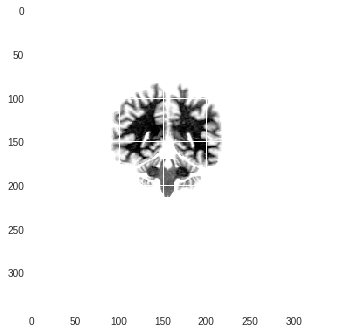

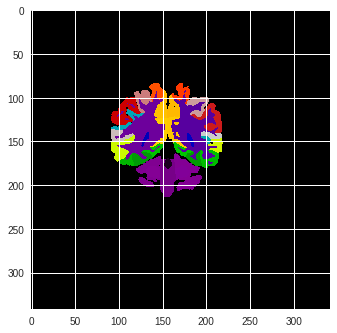

Accuracy is:  79.48880864359027  ; correct and iter are  999598 1257533
Time Taken for testing Patient:  432.59940481185913
To display one slice of the predicted result and difference image :


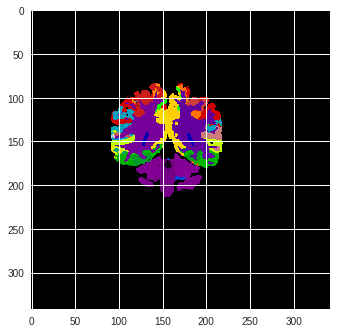

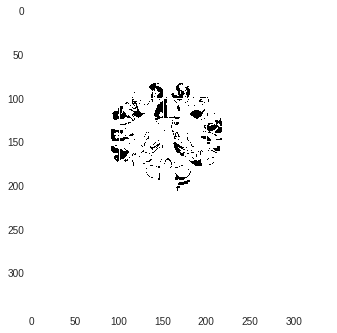

Test Patient Number 1
total number of voxels in the Patient =  46317744
To display one slice of the raw and label image first:


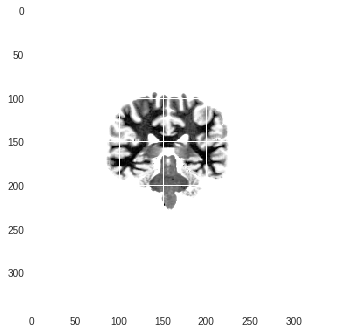

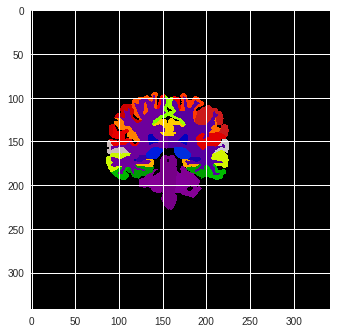

Accuracy is:  79.93265883950808  ; correct and iter are  1181758 1478442
Time Taken for testing Patient:  495.8618257045746
To display one slice of the predicted result and difference image :


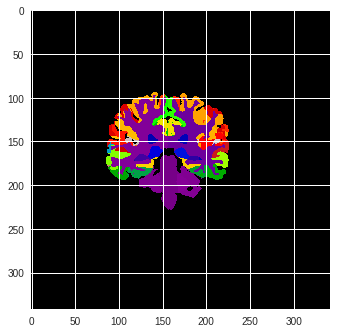

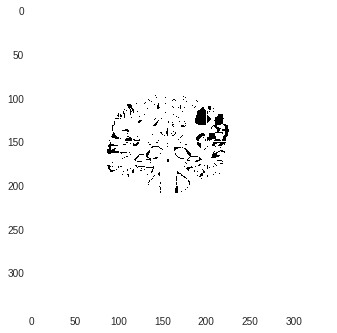

Test Patient Number 2
total number of voxels in the Patient =  43276680
To display one slice of the raw and label image first:


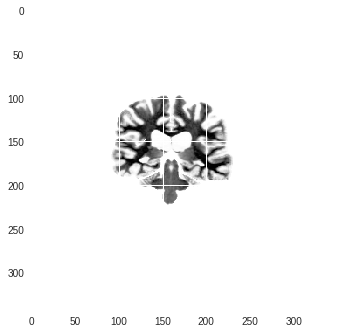

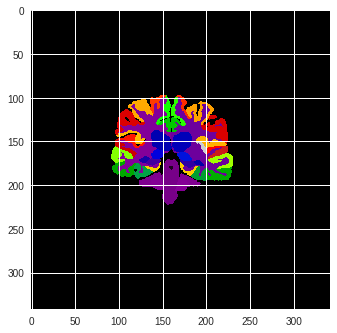

Accuracy is:  75.74682677202907  ; correct and iter are  1048277 1383922
Time Taken for testing Patient:  460.4363751411438
To display one slice of the predicted result and difference image :


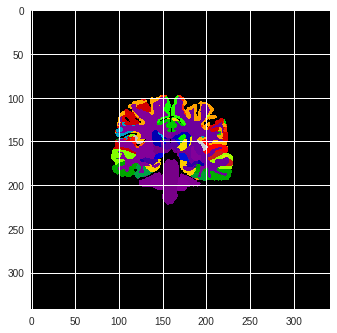

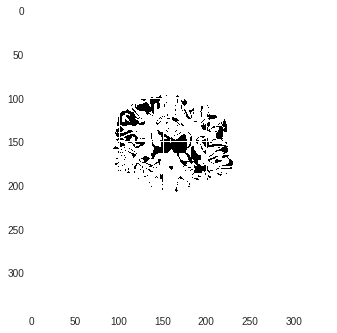

Test Patient Number 3
total number of voxels in the Patient =  44095428
To display one slice of the raw and label image first:


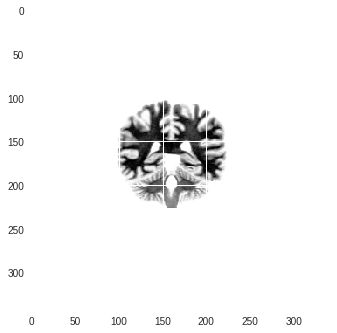

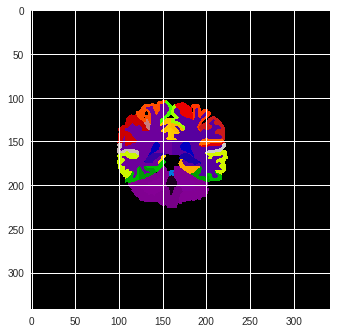

Accuracy is:  80.30370728489073  ; correct and iter are  920205 1145906
Time Taken for testing Patient:  398.01108288764954
To display one slice of the predicted result and difference image :


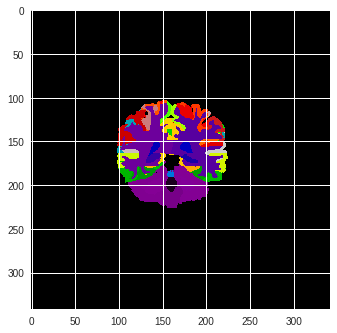

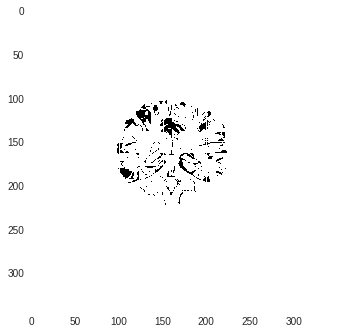

Test Patient Number 4
total number of voxels in the Patient =  45732924
To display one slice of the raw and label image first:


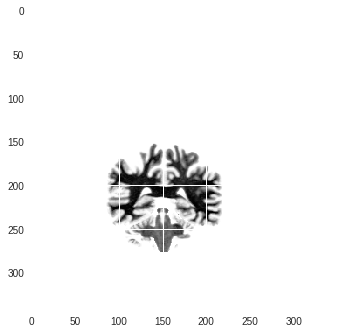

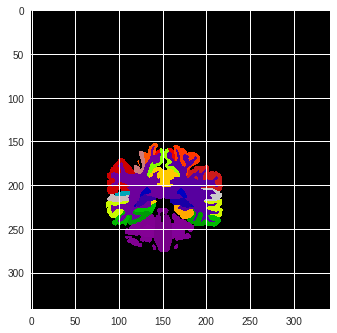

Accuracy is:  76.58326197680884  ; correct and iter are  897951 1172516
Time Taken for testing Patient:  408.2641475200653
To display one slice of the predicted result and difference image :


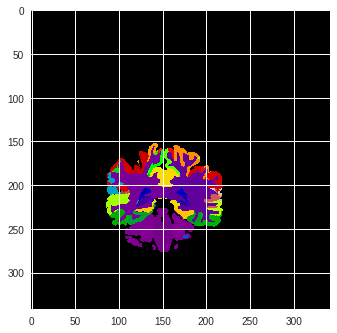

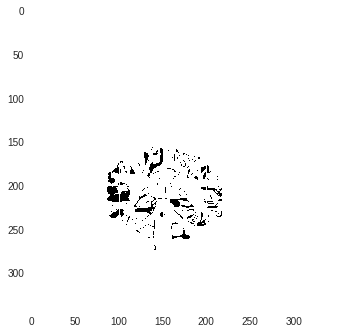

All the patients are completed !


In [20]:
import gc
import copy
import matplotlib.pyplot as plt
import time

# To reload the model parameters
test.load_weights("drive/My Drive/Colab Notebooks/model.h5")
print("Model Restored")
t1=[]
t4=[]
t7=[]
t8=[]
t9=[]
t10=[]
t11=[]

print("---------------------Start the Prediction: ------------------------")
for i in range(0,len(dataset)):   
  print("Test Patient Number " + str(i))
  total = np.size(dataset[i][0])
  print("total number of voxels in the Patient = ",total)
  # image[i] contains the labels of the dataset
  #true_labels = copy.deepcopy(image[i])  #this command is needed for making a clean copy
  true_labels = copy.deepcopy(dataset[i][1])
  #
  iter = 0
  correct = 0
  start = 0   #342*342*160            #0
  end = total #342*342*160 + 116964*5 #total
  raw = dataset[i][0]
  
  print("To display one slice of the raw and label image first:")
  # To show the raw image, slice 160
  plt.imshow(dataset[i][0][160])
  plt.show()
  # To show the label image, slice 160
  plt.imshow(dataset[i][1][160],cmap='nipy_spectral',interpolation='nearest')
  plt.show()
  
  start_time = time.time()
  # print("Starting recording test time for the patient")
  for j in range (start,end):
    stime = time.time()
    voxel = j
    # PREDICTION for every FIVE layers:
    # The IF statement to predict is carried out when
    # ( end of 5 layers OR coming to the last voxel )
    # 
    # Only predict if the voxel is non-zero within those 5 layers
    # 
    if(((j+1)%(342*342*5)==0 or (j+1) == end) and len(t1)>0):
      #
      # TO PREDICT/ CARRY OUT SEGMENTATION
      pred = test.predict([t1,t4,t7])
      
      # After prediction:
      # assign the prediction result to image, with the x,y,z locations
      #
      pred_labelimage[i][t9,t10,t11] = np.argmax(pred,axis=1)
      
      # compare between the pred result and the groundtruth (t8); #correct
      correct += np.sum(np.equal(np.argmax(pred,axis=1),t8))
      
      # total number of voxels predicted is iter
      iter += len(np.equal(np.argmax(pred,axis=1),t8))
      
      # Clean up the array for the next round
      t1=[]
      t4=[]
      t7=[]
      t8=[]
      t9=[]
      t10=[]
      t11=[] 
      gc.collect()

    # 
    # TO APPEND data array for the next round of prediction
    # find the voxel x,y,z values
    z_layer = (voxel//116964)
    row = (voxel%116964)//342
    col = (voxel%116964)%342
    value = dataset[i][1][z_layer][row][col]
    # Here, we ignore and not append to data array if value = 0 (background voxel)
    if(value==0):
      continue
    
    # If the value is non-zero. we will extract the slice raw values for testing
    small_x = raw[z_layer][row-14:row+15,col-14:col+15]
    large_x = raw[z_layer][row-43:row+44,col-43:col+44]
    vol = raw[z_layer-6:z_layer+7,row-6:row+7,col-6:col+7]
    
    small_x = np.reshape(small_x, (29,29,1))
    large_x = np.reshape(large_x, (87,87,1))
    vol = np.reshape(vol, (13,13,13,1))
      
    t1.append(small_x)
    t4.append(large_x)
    t7.append(vol)
    t8.append(value)
    t9.append(z_layer)
    t10.append(row)
    t11.append(col)
    
  # When coming to here, the entire set of voxels has been completed
  print("Accuracy is: ",(correct/iter)*100," ; correct and iter are ",correct, iter ) 
  print("Time Taken for testing Patient: ", time.time()-start_time)
  
  # FINISHED testing and showing the accuracy of one patient 
  #
  # To show the predicated result of one slice (slice 160) from the CNN
  print("To display one slice of the predicted result and difference image :")
  plt.imshow(pred_labelimage[i][160],cmap='nipy_spectral',interpolation='nearest')
  plt.show()
  
  difference_mask = pred_labelimage[i][160] != true_labels[160]
  difference = difference_mask*true_labels[160]
  difference[difference>0] = 255 # make this area dark
   # To show the difference image
  plt.imshow(difference)
  plt.show()
  
  # Saving the result of just one slice to the folder
  np.save("drive/My Drive/Colab Notebooks/Test_output_" + str(i) + "_"+str(path[len(path)-5:-4])+ ".npy",pred_labelimage[i][160])
  np.save("drive/My Drive/Colab Notebooks/Test_raw_" + str(i) + "_"+str(path[len(path)-5:-4])+ ".npy",dataset[i][0][160][160])
  np.save("drive/My Drive/Colab Notebooks/Test_label_" + str(i) + "_"+str(path[len(path)-5:-4])+ ".npy",dataset[i][1][160])
  np.save("drive/My Drive/Colab Notebooks/Test_diff_" + str(i) + "_"+str(path[len(path)-5:-4])+ ".npy",difference)
  
  # Saving the result patient i to the folder
  np.save("drive/My Drive/Colab Notebooks/Patient_output_" + str(i) + "_"+str(path[len(path)-5:-4])+ ".npy",pred_labelimage[i])
  # np.save("output_" + str(i) + "_"+str(path[len(path)-5:-4])+".npy",image[i])
print("All the patients are completed !")

Dice Coefficient Calculation

In [0]:
def eval(true,predicted):
  # ground_turth is true; 
  true_labels = list(range(1,135))
  dices = []
  tester = []

  # for each class, (true==num) gives a boolean array assigned to masker
  # true_labels is [1 2 3 4 .... 134]
  for num in (true_labels):
    if (num in true):
      masker = (true==num)
      # multiply the masker to the ground_truth(true) gives the true_mask
      true_mask = masker*true 
      # multiply the masker to the predicted gives the pred_mask
      pred_mask = masker*predicted
      #(pred_mask==num) gives those correctly identified
      numerator = 2*np.count_nonzero(pred_mask==num) 
      # denominator is the sum of the voxels in that class label, together 
      # with the number of voxels predicted to that class
      denominator = np.count_nonzero(true==num)+np.count_nonzero(predicted==num)
      dice = numerator/denominator
      dices.append(dice)
      tester.append([num,dice,numerator,denominator])
  print(tester) # detailed print out
  print("Average dice coefficient for all classes:",100*sum(dices)/len(dices) )
  return sum(dices)/len(dices)

Calling the DICE function to calculate the prediction dice of each patient

[[1, 0.7501921598770177, 976, 1301], [2, 0.7966533284830848, 2190, 2749], [3, 0.5206812652068127, 428, 822], [4, 0.718052738336714, 708, 986], [5, 0.6200873362445415, 1136, 1832], [6, 0.48128342245989303, 720, 1496], [7, 0.9238024586689275, 34868, 37744], [8, 0.8560552657549697, 6072, 7093], [9, 0.8425713849442663, 5518, 6549], [10, 0.9501200686106347, 96936, 102025], [11, 0.8553946162907378, 78426, 91684], [12, 0.890990895242144, 25150, 28227], [13, 0.8594025797691786, 25318, 29460], [14, 0.9232313918344347, 360448, 390420], [15, 0.9150631275215103, 350428, 382955], [16, 0.7399141630901288, 1724, 2330], [17, 0.8005746375865221, 6130, 7657], [18, 0.7837271911456776, 5240, 6686], [19, 0.303951367781155, 200, 658], [20, 0.475, 266, 560], [21, 0.788564376799671, 3834, 4862], [22, 0.7871367458327186, 5336, 6779], [23, 0.8015065913370998, 2128, 2655], [24, 0.8346020761245675, 2412, 2890], [25, 0.8822005674108795, 7152, 8107], [26, 0.8668116992990089, 7172, 8274], [27, 0.8537002806873417, 12

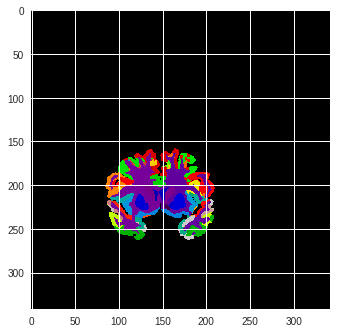

Patient, i =  4
Time Taken for DICE of one Patient:  94.14388799667358


In [22]:
# i is patient number
# patient number is [0,4]
i = 4
# Patient files:Patient_output_0_1.npy; Patient_output_1_1.npy; Patient_output_2_1.npy
#               Patient_output_3_1.npy; Patient_output_4_1.npy
#
# Need to change to file name to match with the value of i
# for i = 0,  output = np.load("drive/My Drive/Colab Notebooks/Patient_output_0_1.npy")
# for i = 1,  output = np.load("drive/My Drive/Colab Notebooks/Patient_output_1_1.npy")

output = np.load("drive/My Drive/Colab Notebooks/Patient_output_4_1.npy")
#
#
npad = ((43,43), (43,43), (43,43))

start_time = time.time()
dataset = np.load("drive/My Drive/MRI/Dataset_final_test_1.npy")
dataset[i][1] = np.pad(dataset[i][1], pad_width=npad, mode='constant', constant_values=0)
#
print(eval(dataset[i][1],output))
#
from matplotlib import pyplot
from pylab import *
print(output.shape)
imshow(output[200],cmap='nipy_spectral',interpolation='nearest')
plt.show()
print("Patient, i = ", i)
print("Time Taken for DICE of one Patient: ", time.time()-start_time)


In [0]:
""" irrelevant 
# This is the function to show the difference between the predicted and ground truth image
def dice_diff(true,predicted):
  """
"""
  true_labels = [4, 11, 23, 30, 31, 32, 35, 36, 37, 38, 39, 40, 41, 44, 45, 46, 47, 48, 49, 50, 51, 52, 55, 56, 57,
                   58, 59, 60, 61, 62, 69, 71, 72, 73, 75, 76, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 112,
                   113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 128, 129, 132, 133, 134, 135, 136,
                   137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
                   157, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178,
                   179, 180, 181, 182, 183, 184, 185, 186, 187, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200,
                   201, 202, 203, 204, 205, 206, 207]
 """
  """
  true_labels = list(range(1,135))
  dices = []
  tester = []
  master = np.zeros(true.shape,dtype=float)
  
  
  for num in (true_labels):
    if (num in true):
      masker = (true==num)
      true_mask = masker*true
      pred_mask = masker*predicted
      temp = true_mask!= pred_mask
      temp = true_mask*temp
      temp[temp>0] = 255
      master += temp
      numerator = 2*np.count_nonzero(pred_mask==num)
      
      denominator = np.count_nonzero(true==num)+np.count_nonzero(predicted==num)
      dice = numerator/denominator
      dices.append(dice)
      tester.append([num,dice,numerator,denominator])
  print(tester)
  return sum(dices)/len(dices), master
  """

In [0]:
""" irrelevant 
#This is the code for correcting for bias field effect and generating the numpy files
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import os
#from __future__ import print_function


# Path to a T1-weighted brain .nii image:
normal = "drive/My Drive/Colab Notebooks/testing/mri/"
corrected = "drive/My Drive/Colab Notebooks/corrected/test/"
path = "drive/My Drive/Colab Notebooks/Dataset_final_test_4.npy"
print(os.listdir(normal))
output_file = np.load(path)
counter = 0

for i in os.listdir(normal):
  if(counter<15):
    counter += 1
    continue
  if(counter==22):
    break
  intput = sitk.ReadImage(normal+i)
  input_arr = sitk.GetArrayFromImage(intput)
  print(input_arr.shape)
  
  
  output_arr = output_file[counter%5][1]
  print(output_arr.shape)
  #create boolean mask of brain tissue
  mask = output_arr>0
  #mask the original image to only have the brain
  input_arr = input_arr*mask
  #save the array as a .nii file
  file = sitk.GetImageFromArray(input_arr)
  sitk.WriteImage(file,i)
  
  #reading the saved masked .nii file
  inputImage = sitk.ReadImage(i)
  #thresholding for brain tissue value
  maskImage = sitk.OtsuThreshold(inputImage,0,1,10)
  inputImage = sitk.Cast( inputImage, sitk.sitkFloat32 )
  
  #Bias Correction Filter Object
  corrector = sitk.N4BiasFieldCorrectionImageFilter();

  numberFittingLevels = 4
  #print("initialized")
  corrector.SetMaximumNumberOfIterations( [1] *numberFittingLevels  )
  
  #Do the correction on the input image.
  output = corrector.Execute( inputImage, maskImage)
  #save the bias corrected nii file.
  sitk.WriteImage( output, corrected+i)
  
  #reload the nii file.
  intput = sitk.ReadImage(corrected+i)
  #get array
  input_arr = sitk.GetArrayFromImage(intput)
  
  print(input_arr.shape)
  print(len(np.unique(output_file[counter%5][0])))
  output_file[counter%5][0] = input_arr
  print(output_file[counter%5][0].shape)
  print(output_file[counter%5][1].shape)
  print(len(np.unique(output_file[counter%5][0])))
  
  #
  print(corrected+i)
  counter += 1
  #save as numpy file with 5 patients
np.save(path,output_file)
"""

2
